In [660]:
from Network import PINN, NetworkTrainer
from Physics import *
from Physics import NVS

In [661]:
model0 = PINN(width=64, length=6, is_steady=True)

## Define Physical Space

torch.Size([40000])


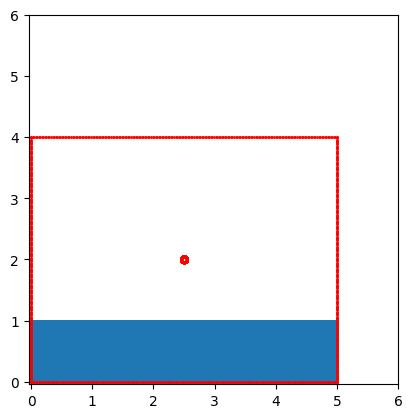

In [662]:
import matplotlib.pyplot as plt
from PointSampling import Bound, PhysicsBound
import torch

bound_list = []
def func1(x):
    return 4*torch.ones_like(x)
bound_list.append(Bound([0,5], func1, True))
def func2(x):
    return 0*torch.ones_like(x)
bound_list.append(Bound([0,5], func2, False))

def func3(y):
    return 0*torch.ones_like(y)
bound_list.append(Bound([0,4], func3, False, ref_axis='y'))
def func4(y):
    return 5*torch.ones_like(y)
bound_list.append(Bound([0,4], func4, True, ref_axis='y'))

def func5(x):
    return torch.sqrt(0.05**2 - (x-2.5)**2)+2
bound_list.append(Bound([2.45,2.55], func5, False, ref_axis='x', is_true_bound=False))
def func6(x):
    return -torch.sqrt(0.05**2 - (x-2.5)**2)+2
bound_list.append(Bound([2.45,2.55], func6, True, ref_axis='x', is_true_bound=False))

X, Y = Bound.sampling_area(bound_list, 200, [0,5], [0,1])
print(X.shape)
xxx = X
yyy = Y
plt.figure()
plt.scatter(X,Y,s=1)
for bound in bound_list:
    x,y = bound.sampling_line(200)
    plt.scatter(x,y,s=1, color='red')
plt.xlim(-0.04,6)
plt.ylim(-0.04,6)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### Define Boundary Conditions and PDE Area

In [663]:
physics_cond_list = [
    {'u': 0.05, 'v': 0.0},  # func1: top wall (y=1) -> No-slip
    {'u': 0.05, 'v': 0.0},  # func2: bottom wall (y=0) -> No-slip
    {'u': 0.05, 'v': 0.0},  # func3: inlet (x=0) -> Uniform inflow
    {'u': 0.05, 'v': 0.0},             # func4: outlet (x=2) -> Zero pressure
    {'u': 0.0, 'v': 0.0},
    {'u': 0.0, 'v': 0.0},
]
boundary_conditions_list = []
iii = [0,1,2,3,4,5]
for i in iii:
    boundary_conditions_list.append(PhysicsBound.define_boundary_condition(bound_list[i], physics_cond_list[i]))


from Physics import NVS
area_physics_bound = PhysicsBound.define_pde_area(bound_list=bound_list, sampling_range_x=[0,5], sampling_range_y=[0,4], PDE_class=NVS(is_steady=True))

### Sampling points

In [664]:
def uniform_sampling():
    for bc in boundary_conditions_list:
        bc.sampling_collocation_points(1000)
    area_physics_bound.sampling_collocation_points(100)

def random_sampling():
    for bc in boundary_conditions_list:
        bc.sampling_collocation_points(400,True)
    area_physics_bound.sampling_collocation_points(20,True)

## Define Physics

In [665]:
loss_fn = torch.nn.MSELoss()
def get_loss():

    random_sampling()

    #bc_loss
    bc_loss = 0
    for bc in boundary_conditions_list:
        bc_loss += bc.calc_loss(model0, loss_fn)

    #pde_loss
    pde_loss = area_physics_bound.calc_loss(model0)

    #total_loss
    total_loss = bc_loss + 5*pde_loss
    
    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [666]:
model1 = NetworkTrainer.train_adam(model=model0, calc_loss=get_loss, learning_rate=0.001, epochs=1000, print_every=100)

epoch 1, total_loss: 0.03289, bc_loss: 0.03277, pde_loss: 0.00003
epoch 101, total_loss: 0.00056, bc_loss: 0.00032, pde_loss: 0.00005
epoch 201, total_loss: 0.00042, bc_loss: 0.00027, pde_loss: 0.00003
epoch 301, total_loss: 0.00038, bc_loss: 0.00024, pde_loss: 0.00003
epoch 401, total_loss: 0.00034, bc_loss: 0.00023, pde_loss: 0.00002
epoch 501, total_loss: 0.00029, bc_loss: 0.00024, pde_loss: 0.00001
epoch 601, total_loss: 0.00025, bc_loss: 0.00019, pde_loss: 0.00001
epoch 701, total_loss: 0.00025, bc_loss: 0.00018, pde_loss: 0.00001
epoch 801, total_loss: 0.00025, bc_loss: 0.00020, pde_loss: 0.00001
epoch 901, total_loss: 0.00034, bc_loss: 0.00026, pde_loss: 0.00002


In [667]:
def random_sampling():
    for bc in boundary_conditions_list:
        bc.sampling_collocation_points(2500,True)
    area_physics_bound.sampling_collocation_points(100,True)

In [668]:
model2 = NetworkTrainer.train_adam(model=model1, calc_loss=get_loss, learning_rate=0.0001, epochs=2000, print_every=100)

epoch 1001, total_loss: 0.00023, bc_loss: 0.00019, pde_loss: 0.00001
epoch 1101, total_loss: 0.00019, bc_loss: 0.00014, pde_loss: 0.00001
epoch 1201, total_loss: 0.00018, bc_loss: 0.00014, pde_loss: 0.00001
epoch 1301, total_loss: 0.00019, bc_loss: 0.00013, pde_loss: 0.00001
epoch 1401, total_loss: 0.00018, bc_loss: 0.00013, pde_loss: 0.00001
epoch 1501, total_loss: 0.00017, bc_loss: 0.00013, pde_loss: 0.00001
epoch 1601, total_loss: 0.00015, bc_loss: 0.00011, pde_loss: 0.00001
epoch 1701, total_loss: 0.00016, bc_loss: 0.00011, pde_loss: 0.00001
epoch 1801, total_loss: 0.00015, bc_loss: 0.00011, pde_loss: 0.00001
epoch 1901, total_loss: 0.00014, bc_loss: 0.00010, pde_loss: 0.00001
epoch 2001, total_loss: 0.00014, bc_loss: 0.00010, pde_loss: 0.00001
epoch 2101, total_loss: 0.00013, bc_loss: 0.00009, pde_loss: 0.00001
epoch 2201, total_loss: 0.00012, bc_loss: 0.00009, pde_loss: 0.00001
epoch 2301, total_loss: 0.00012, bc_loss: 0.00009, pde_loss: 0.00001
epoch 2401, total_loss: 0.00012, b

# Visualization

In [669]:
from Utility import *
import numpy as np
area_physics_bound.sampling_collocation_points(300)
X,Y,U,V,P,T = area_physics_bound._process_model(model1)
residual = area_physics_bound._get_pde_residual_sum(model1)
X,Y,U,V,P,residual = torch_to_numpy([X,Y,U,V,P,residual])
V_size = np.sqrt(U**2+V**2)


In [670]:
print(P.shape,X.shape)

(89964, 1) (89964, 1)


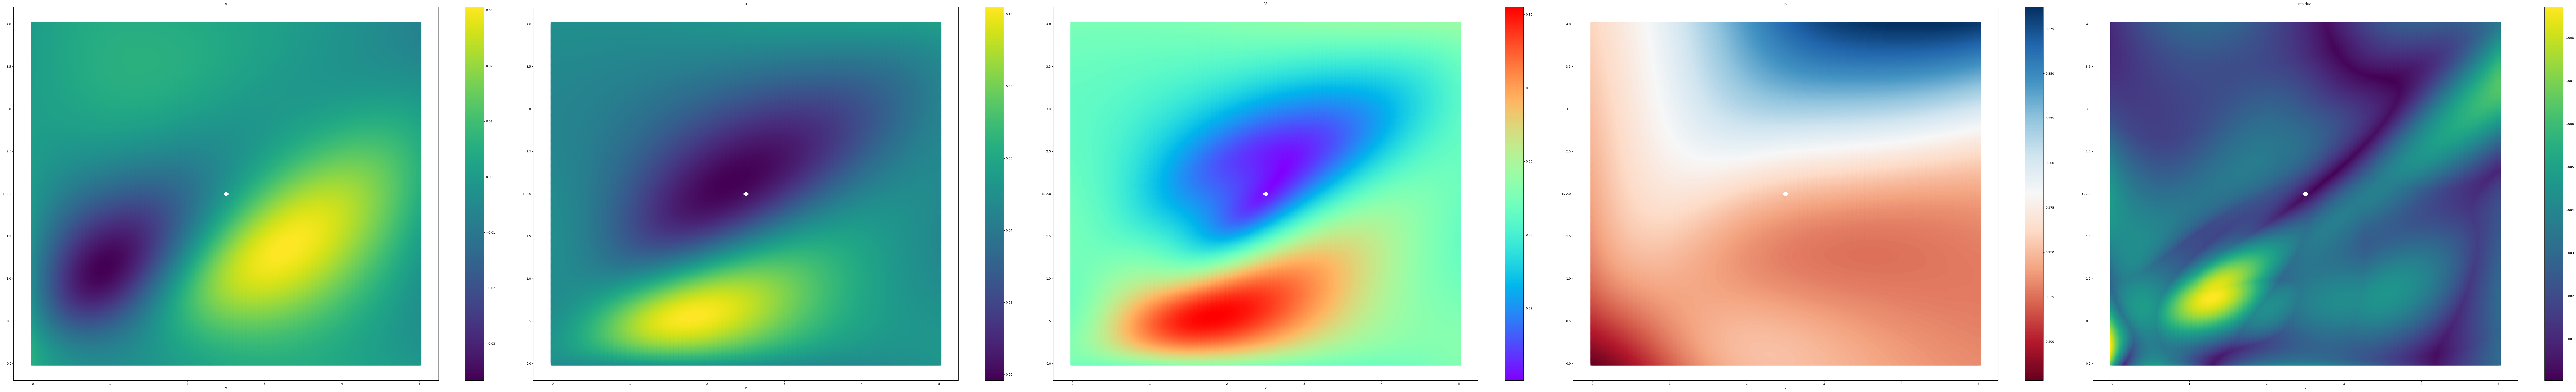

In [671]:
from Visualize import Visualization
import numpy as np
fig, axes = plt.subplots(1,5, figsize=(6*10*2,18))
s =150
Visualization.colorplot(X.flatten(),Y.flatten(),V.flatten(),axes[0],'v','viridis',s)
Visualization.colorplot(X.flatten(),Y.flatten(),U.flatten(),axes[1],'u','viridis',s)
Visualization.colorplot(X.flatten(),Y.flatten(),V_size.flatten(),axes[2],'V','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),P.flatten(),axes[3],'p','RdBu',s)
Visualization.colorplot(X.flatten(),Y.flatten(),residual.flatten(),axes[4],'residual','viridis',s)

plt.tight_layout()
plt.show()

In [672]:
boundary_conditions_list[3].sampling_collocation_points(100)
boundary_conditions_list[3].PDE = NVS()
X,Y,U,V,P,T = boundary_conditions_list[3]._process_model(model1)
X,Y,U,V,P = torch_to_numpy([X,Y,U,V,P])


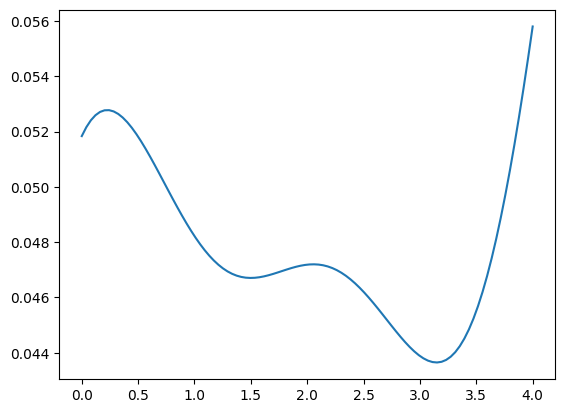

In [673]:
plt.plot(Y.flatten(), U.flatten())
plt.show()

In [674]:
fig.savefig('backward_stepflow_steady.png')